In [1]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
%matplotlib inline

In [2]:
engine = create_engine('sqlite+pysqlite:///../SQL/testbobo.db')
import time
start_time = time.time()
#ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
#Hitdf = pd.io.sql.read_sql("SELECT * FROM Hit", engine)
#PSAdf = pd.io.sql.read_sql("SELECT * FROM PSA", engine)
ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
#RawADCdf = pd.io.sql.read_sql("SELECT * FROM RawADC", engine)
end_time = time.time()
print end_time-start_time

0.0418560504913


In [3]:
#Hitdf[Hitdf['EventID']==0]

(-15, 15)

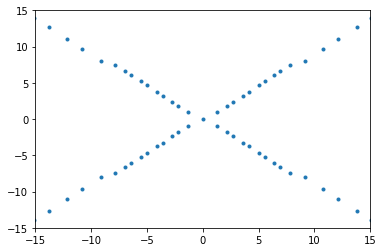

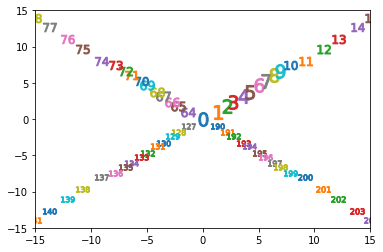

In [6]:
#print ProtoMapdf
plt.scatter(ProtoMapdf.iloc[:252]['PadX'],ProtoMapdf.iloc[:252]['PadY'],marker='.')
plt.xlim([-15,15])
plt.ylim([-15,15])
plt.figure()
for row in ProtoMapdf.iloc[:252].iterrows():
    plt.scatter(row[1]['PadX'],row[1]['PadY'],marker='${}$'.format(row[1]['PadNum']),s=200) 
plt.xlim([-15,15])
plt.ylim([-15,15])